In [ ]:
### Notebook to reformat data from old codebase into new codebase formats

/accounts/projects/sewonm/prasann/.conda/envs/scaling2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import Dataset, DatasetDict
from setretrieval.utils.utils import pickload, pickdump
import matplotlib.pyplot as plt

/accounts/projects/sewonm/prasann/.conda/envs/scaling2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
fifteen = Dataset.load_from_disk("../data/datastores/wikipedia_docs_15k")

In [6]:
smallset = fifteen.select(range(10))
smallset.save_to_disk("../data/datastores/wikipedia_docs_debug10")

Saving the dataset (1/1 shards): 100%|██████████| 10/10 [00:00<00:00, 1679.27 examples/s]


In [53]:
wdatafull = pickload("../data/datastores/wikipedia_docs_8chunksparagraph.pkl")
wflat = [item for sublist in wdatafull for item in sublist]

In [55]:
weirdcount = 0
for w in wflat:
    w['text'] = str(w['text'])
    if type(w['id']) != int:
        w['id'] = -1
        weirdcount += 1
print(f"weirdcount: {weirdcount}")

weirdcount: 0


In [ ]:
f2ind = {row['text']: i for i, row in enumerate(wflat)}
wfset = set(row['text'] for row in wflat)

In [61]:
dset12k = Dataset.from_list(wflat[62000:77000])

In [ ]:
dset12k.save_to_disk("../data/datastores/wikipedia_docs_15k")

In [62]:
dset12k.save_to_disk("../data/datastores/wikipedia_docs_15k")
# Dataset.from_list(wflat).save_to_disk("../data/datastores/wikipedia_docs_150k")

Saving the dataset (1/1 shards): 100%|██████████| 15000/15000 [00:00<00:00, 100512.93 examples/s]


In [ ]:
# did the full one in the original notebook, TODO can put this stuff together later into smth reproducible

In [ ]:
qdata = Dataset.load_from_disk("../data/evalsets/distractor_queries_settestdata")
allpos = [r['pos_chunks'] for r in qdata]
allposflat = [item for sublist in allpos for item in sublist]

In [34]:
allinds = [f2ind[item] for item in set(allposflat)]

(array([135., 146., 161., 157., 171., 176., 142., 169., 176., 161., 157.,
        139., 166., 172., 142., 154., 164., 164., 153., 138., 158., 166.,
        153., 157., 159., 145., 139., 157., 172., 162., 167., 146., 161.,
        151., 168., 161., 163., 184., 149., 163., 156., 170., 160., 159.,
        156., 151., 158., 152.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([65036.  , 65244.74, 65453.48, 65662.22, 65870.96, 66079.7 ,
        66288.44, 66497.18, 66705.92, 66914.66, 67123.4 , 67332.14,
        67540.88, 67749.62, 67958.36, 68167.1 , 68375.84, 68584.58,
        68793.32, 69002.06, 69210.8 , 69419.54, 69628.28, 69837.02,
        70045.76, 70254.5 , 70463.24, 70671.98

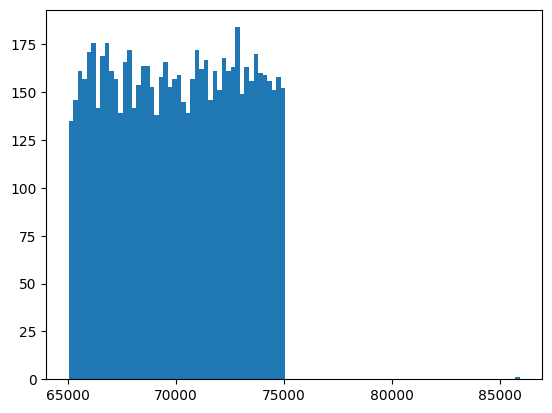

In [35]:
plt.hist(allinds, bins=100)

In [8]:
qdset = Dataset.from_list(qdata)

In [9]:
qdset[0]

{'question': 'Which passage describes a project being revived after a period of political suppression?',
 'goldind': [1354, 1360, 5388, 7755],
 'pos_chunks': ['The Kharkiv School of Photography (KSOP) () is a Ukrainian artistic photography movement. It was created in opposition to the Soviet socialist realism art style, which reigned from 1934 until the 1980s. KSOP started to form in the 1960s when artistic photography revived in Kharkiv during the period of the Khrushchev Thaw. KSOP\'s official formation as a non-conformist underground movement was denoted by the establishment of a group by Kharkiv photographers named the Vremia Group 1971; its foundation is considered the sign of the revival of modernist art in Kharkiv.\n\t\nThe Vremia Group built upon avant-garde traditions and brought socialist realism dogmas into play. They are known for extreme experimentations with photography techniques and methods and are credited for inventing and developing a number of them. One of their sig

In [10]:
qdset = qdset.remove_columns(["goldind", "chunks"])

In [11]:
qdset.save_to_disk("../data/evalsets/distractor_queries_settestdata")

Saving the dataset (1/1 shards): 100%|██████████| 572/572 [00:00<00:00, 1983.24 examples/s]


In [12]:
# for initial gemini indoc data, reformat to have format [query, positive, negative], be broken into train / test split
testdata = Dataset.from_json("../data/colbert_training/gemini_indoc_test.jsonl")
traindata = Dataset.from_json("../data/colbert_training/gemini_indoc_train.jsonl")
testdatafilt = Dataset.from_json("../data/colbert_training/gemini_indoc_test_filtered.jsonl")
traindatafilt = Dataset.from_json("../data/colbert_training/gemini_indoc_train_filtered.jsonl")

In [13]:
testdatafilt

Dataset({
    features: ['query', 'pos', 'neg', 'category', 'rephrased_query'],
    num_rows: 2993
})

In [14]:
def reformat_data(row):
    return {
        "query": row['rephrased_query'] if "rephrased_query" in row else row["query"],
        "positive": row["pos"][0],
        "negative": row["neg"][0]
    }

testdata = testdata.map(reformat_data).remove_columns(["pos", "neg", "posind"])
traindata = traindata.map(reformat_data).remove_columns(["pos", "neg", "posind"])
testdatafilt = testdatafilt.map(reformat_data).remove_columns(["pos", "neg", "category", "rephrased_query"])
traindatafilt = traindatafilt.map(reformat_data).remove_columns(["pos", "neg", "category", "rephrased_query"])

Map:   0%|          | 0/27000 [00:00<?, ? examples/s]

Map: 100%|██████████| 27000/27000 [00:03<00:00, 8432.27 examples/s] 


In [18]:
DatasetDict({"train": traindata, "test": testdata}).save_to_disk("../data/colbert_training/gemini_datav1")
DatasetDict({"train": traindata, "test": testdatafilt}).save_to_disk("../data/colbert_training/gemini_ntrain_ptest")
DatasetDict({"train": traindatafilt, "test": testdatafilt}).save_to_disk("../data/colbert_training/gemini_ptrain_ptest")

Saving the dataset (1/1 shards): 100%|██████████| 2993/2993 [00:00<00:00, 49833.88 examples/s]


In [28]:
assert all(type(x) == str for x in testdata["negative"])